In [24]:
import keras

In [25]:
import tensorflow as tf
import pandas as pd 
import random
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, Dot
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify data augmentation and preprocessing options
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Load training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=data_augmentation,
)
train = train_datagen.flow_from_directory(
    r'H:\WorkOut\Research\Tomato Disease Detection\tomato\train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Load validation data
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
val = val_datagen.flow_from_directory(
    r'H:\WorkOut\Research\Tomato Disease Detection\tomato\val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


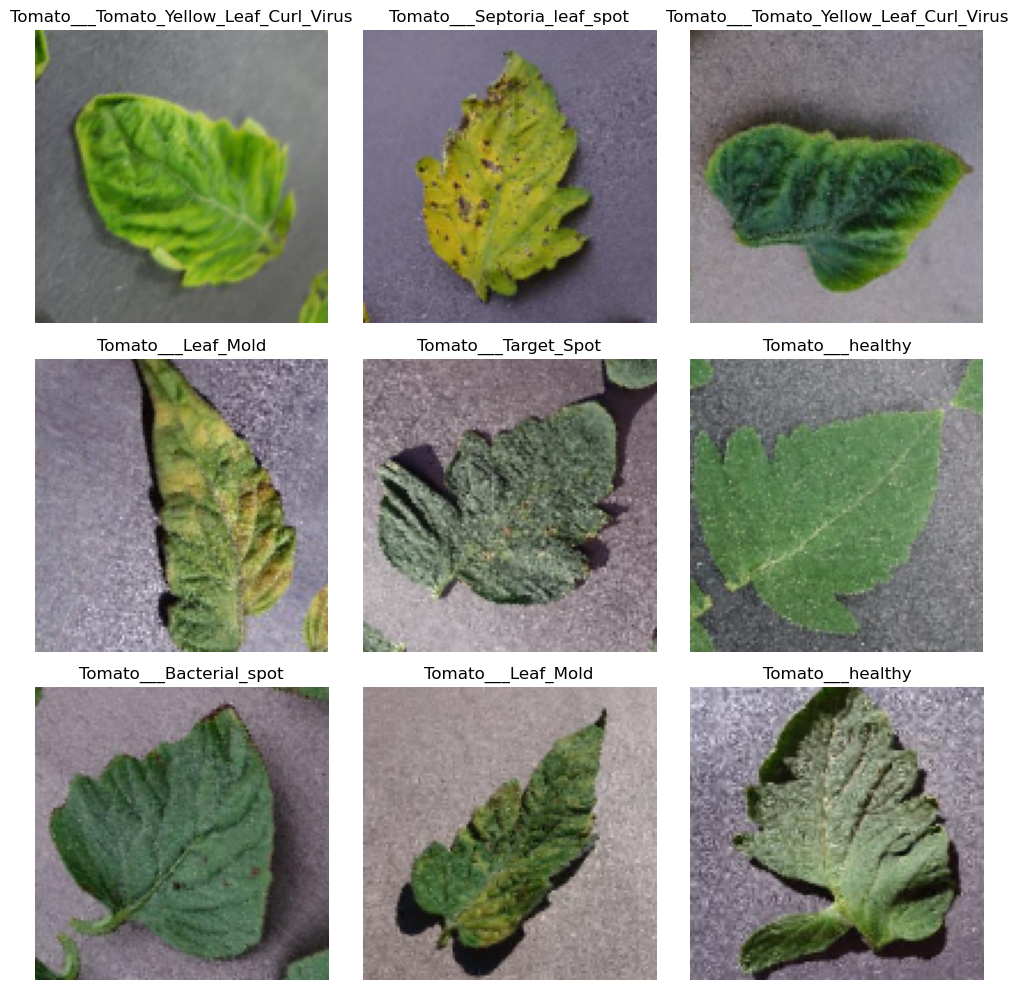

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class names from the generator
class_names = list(train.class_indices.keys())
print(class_names)

# Visualize images with their labels
plt.figure(figsize=(10, 10))
for images, labels in train:
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.uint8(images[i] * 255)) 
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

        if i >= 8:
            break 

    plt.tight_layout()  
    plt.show()
    break  


In [30]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3

Preprocessing

In [34]:
# Normalize and shuffle for train generator
train_generator = train_datagen.flow_from_directory(
    r'H:\WorkOut\Research\Tomato Disease Detection\tomato\train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Shuffle data during each epoch
)

# Normalize for validation generator
val_generator = val_datagen.flow_from_directory(
    r'H:\WorkOut\Research\Tomato Disease Detection\tomato\val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle validation data
)


Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [35]:
train_datagenerator = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, horizontal_flip = True)

In [36]:
valid_datagenerator = ImageDataGenerator(rescale = 1./255)

In [37]:
test_datagenerator = ImageDataGenerator(rescale = 1./255)

In [38]:
train_path =r'H:\WorkOut\Research\Tomato Disease Detection\tomato\train'

In [39]:
train_set = train_datagenerator.flow_from_directory(train_path, target_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical', shuffle=True)

Found 10000 images belonging to 10 classes.


In [40]:
val_path = r'H:\WorkOut\Research\Tomato Disease Detection\tomato\val'

In [41]:
valid_set = valid_datagenerator.flow_from_directory(val_path, target_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical', shuffle=True)

Found 1000 images belonging to 10 classes.


In [42]:
#test dataset making from train dataset
test_set = test_datagenerator.flow_from_directory(train_path, target_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical', shuffle=True)

Found 10000 images belonging to 10 classes.


In [43]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [44]:
model = keras.applications.VGG16(
  weights = "imagenet",
  input_shape = (256, 256, 3),
  include_top = False
)

In [45]:
model = tf.keras.applications.VGG16(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

for layers in model.layers:
  layers.trainable = False

out = tf.keras.layers.Flatten()(model.output)
out = tf.keras.layers.Dense(512, activation="relu")(out)
out = tf.keras.layers.Dense(128, activation="relu")(out)
out = tf.keras.layers.Dropout(0.2)(out)
predict = tf.keras.layers.Dense(10, activation="softmax")(out)

vgg16 = Model(inputs = model.input, outputs = predict)

In [46]:
vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [47]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='loss'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.75
                                            , min_lr=0.00001)

In [48]:
from tensorflow.keras.optimizers import RMSprop
vgg16.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=["accuracy"]
)

epochs = 20
vgg16_history = vgg16.fit(train_set,
                                steps_per_epoch=len(train_set),  
                                validation_data=valid_set,
                                epochs=epochs,
                                callbacks=[learning_rate_reduction],
                                validation_steps=len(valid_set),
                                verbose=1)

Epoch 1/20
313/313 [==============================] - 971s 3s/step - loss: 1.8916 - accuracy: 0.5145 - val_loss: 0.9490 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 987s 3s/step - loss: 0.7851 - accuracy: 0.7396 - val_loss: 0.7396 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 998s 3s/step - loss: 0.6057 - accuracy: 0.7976 - val_loss: 0.8573 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 986s 3s/step - loss: 0.5114 - accuracy: 0.8367 - val_loss: 1.0256 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 984s 3s/step - loss: 0.4447 - accuracy: 0.8518 - val_loss: 0.6972 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 6/20
313/313 [==============================] - 988s 3s/step - loss: 0.4116 - accuracy: 0.8652 - val_loss: 0.7717 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 7/20
313/313 [==============================] - 986s 3s/st

In [49]:
val_score = vgg16.evaluate(valid_set)
val_score

32/32 [==============================] - 85s 3s/step - loss: 0.6790 - accuracy: 0.8400


[0.6790081858634949, 0.8399999737739563]

In [50]:
test_score = vgg16.evaluate(test_set)
test_score

313/313 [==============================] - 854s 3s/step - loss: 0.1681 - accuracy: 0.9470


[0.16814136505126953, 0.9470000267028809]

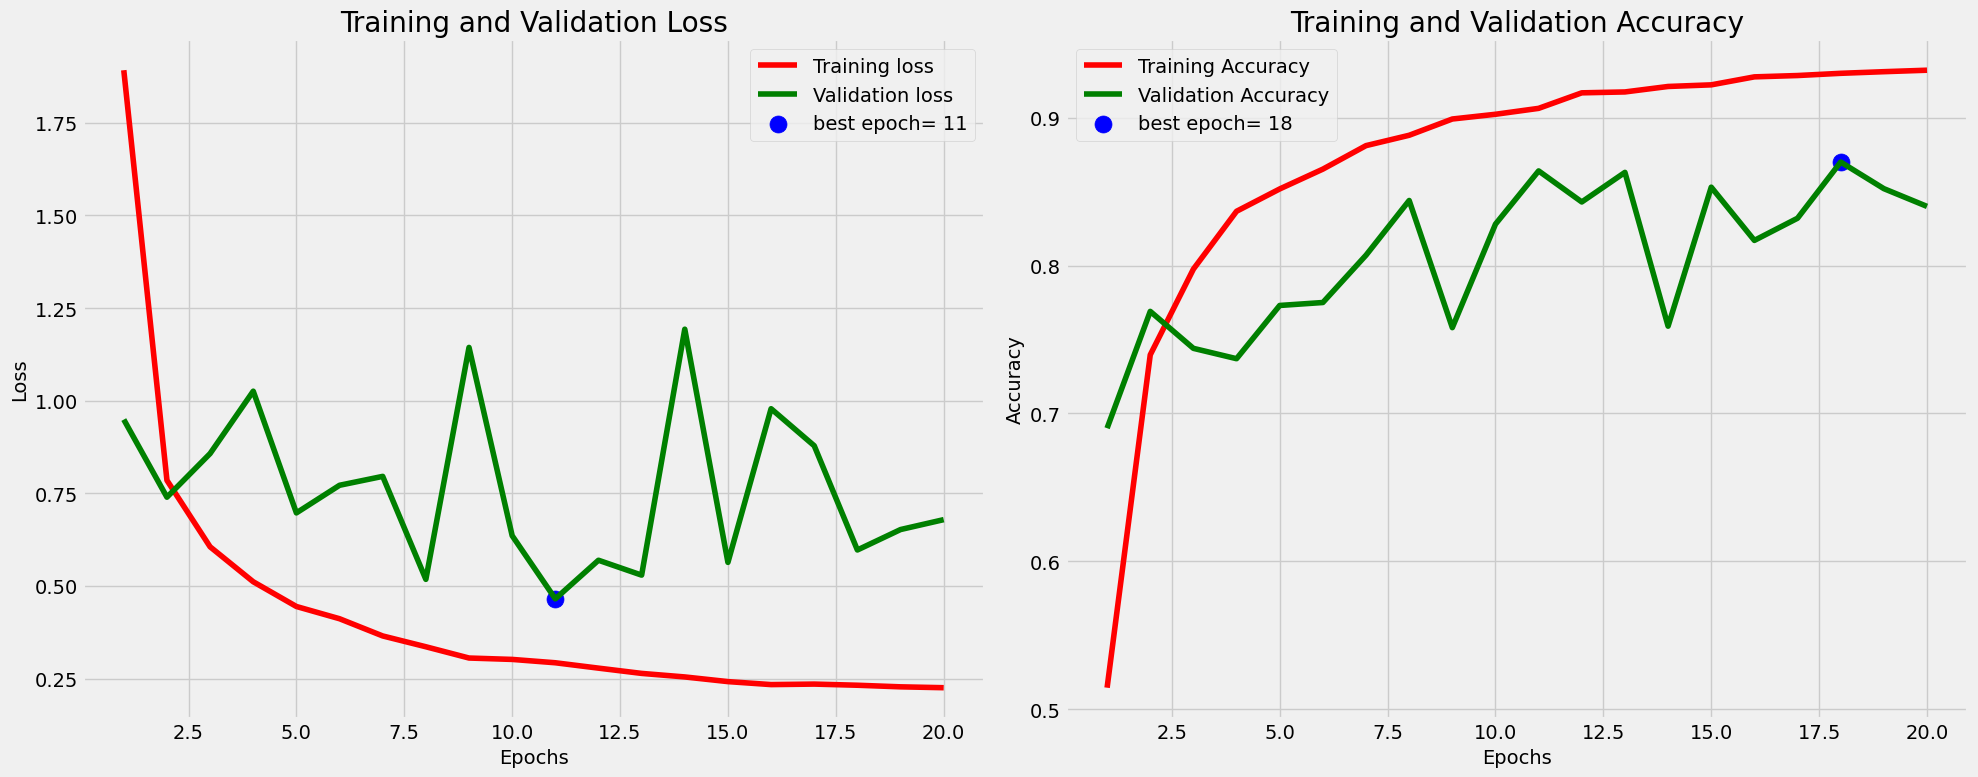

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch + 1, Epoch_count + 1))
    
    index_loss = np.argmin(vloss) if vloss else None
    val_lowest = vloss[index_loss] if index_loss is not None else None
    
    index_acc = np.argmax(vacc) if vacc else None
    acc_highest = vacc[index_acc] if index_acc is not None else None
    
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    if tloss:
        axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    if vloss:
        axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
        if val_lowest is not None:
            axes[0].scatter(index_loss + start_epoch + 1, val_lowest, s=150, c='blue', label=f'best epoch= {index_loss + start_epoch + 1}')
    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    if tacc:
        axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    if vacc:
        axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
        if acc_highest is not None:
            axes[1].scatter(index_acc + start_epoch + 1, acc_highest, s=150, c='blue', label=f'best epoch= {index_acc + start_epoch + 1}')
    
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

tr_plot(vgg16_history, 0)


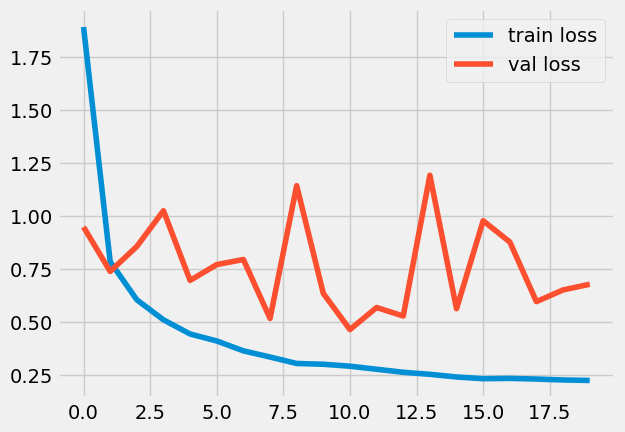

<Figure size 640x480 with 0 Axes>

In [66]:
# Loss
plt.plot(vgg16_history.history['loss'], label='train loss')
plt.plot(vgg16_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

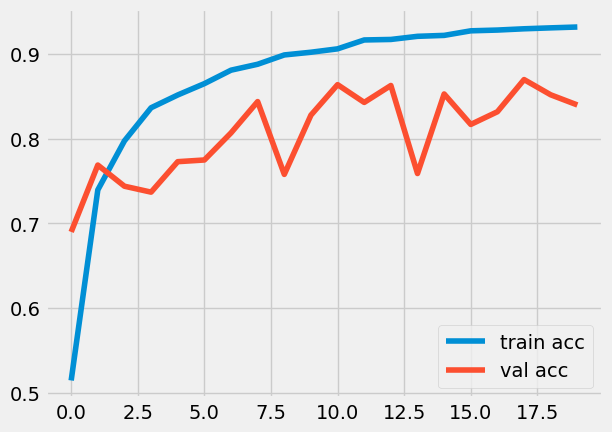

<Figure size 640x480 with 0 Axes>

In [67]:
# Accuracy
plt.plot(vgg16_history.history['accuracy'], label='train acc')
plt.plot(vgg16_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [68]:
class_names = list(train_set.class_indices.keys())
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [69]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 126ms/step


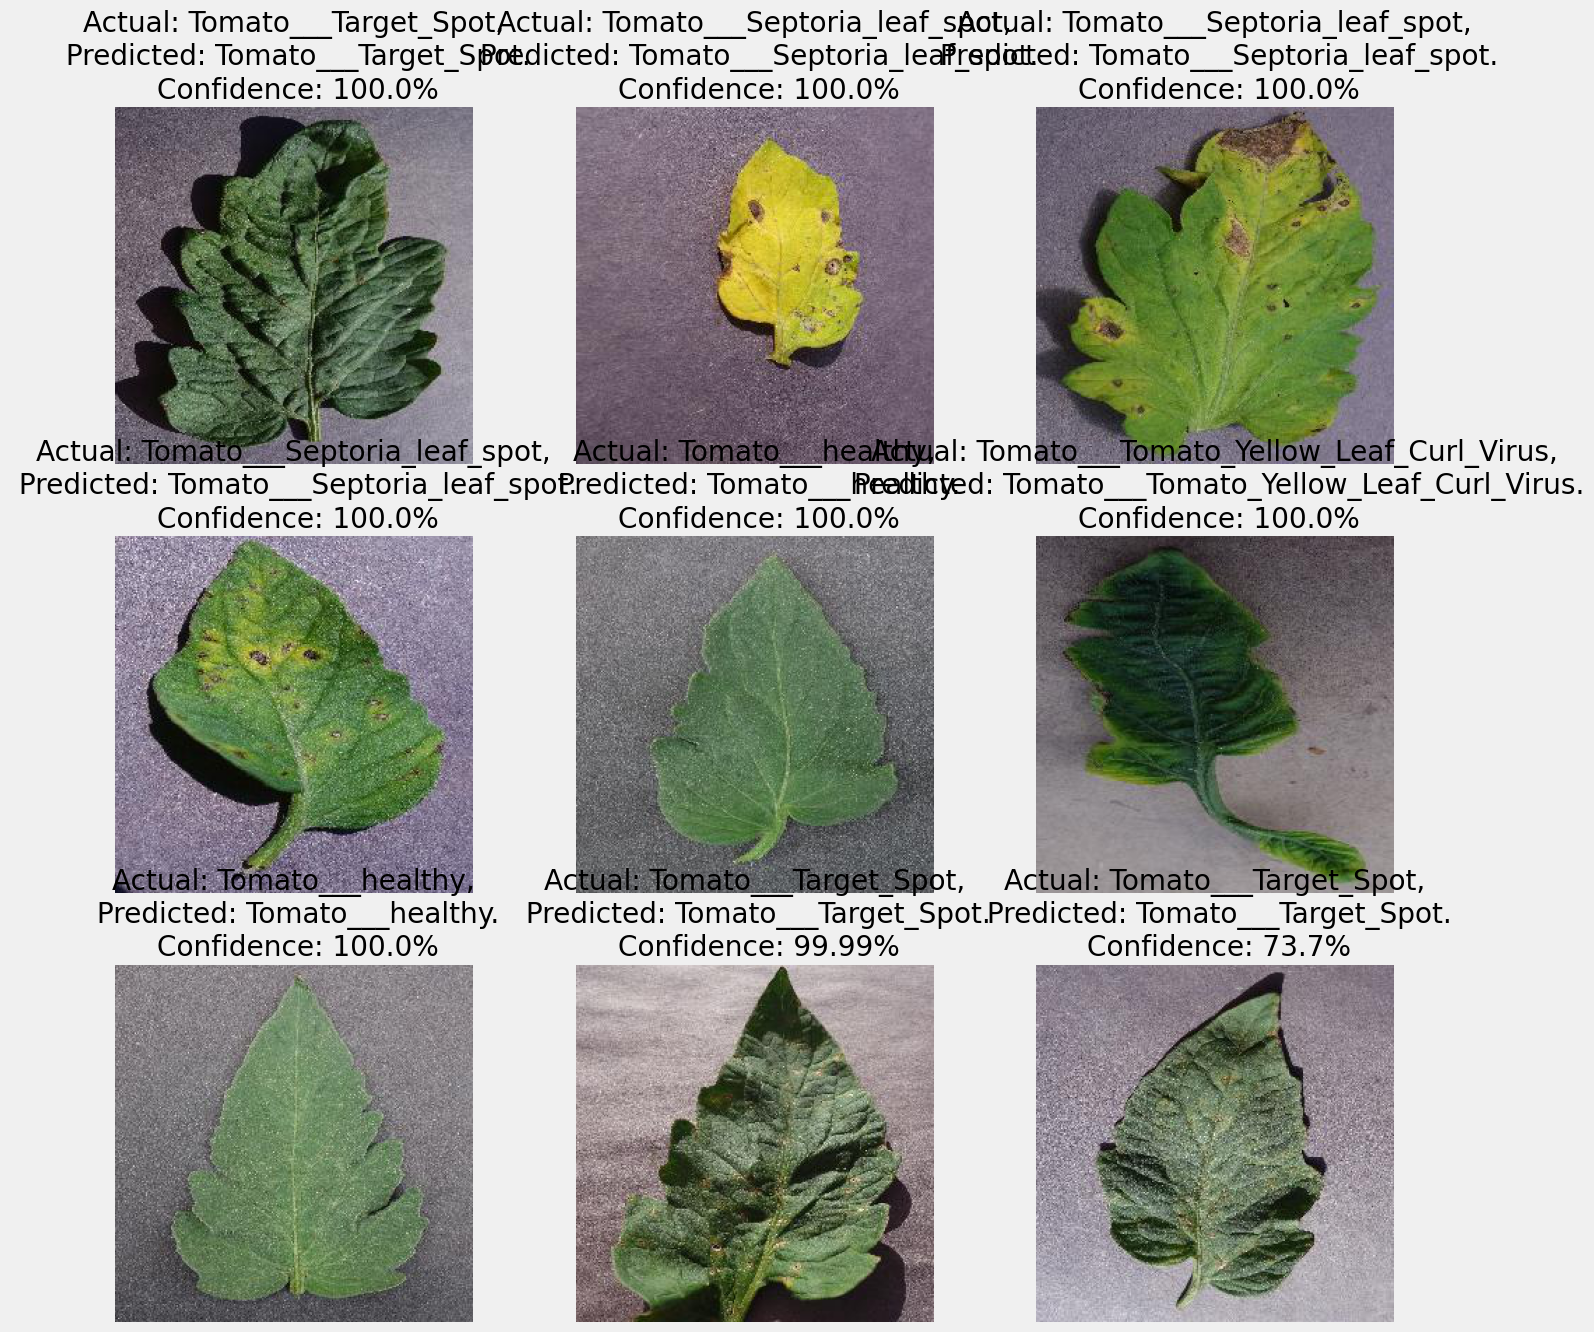

In [70]:
plt.figure(figsize=(15, 15))
for images, labels in test_set:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
        
    predicted_class, confidence = predict(vgg16, images[i])
    index = labels[i].argmax(axis=0)
    actual_class = class_names[index] 
        
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
    plt.axis("off")
  break

In [71]:
from sklearn.metrics import classification_report

x_val, y_val = valid_set.next()

y_pred = vgg16.predict(x_val).round()
target_names = [f"{class_names[i]}" for i in range(10)]
print(classification_report(y_val, y_pred, target_names=target_names))

1/1 [==============================] - 3s 3s/step
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.67      1.00      0.80         2
                        Tomato___Early_blight       0.50      0.50      0.50         2
                         Tomato___Late_blight       1.00      0.33      0.50         3
                           Tomato___Leaf_Mold       1.00      1.00      1.00         1
                  Tomato___Septoria_leaf_spot       1.00      1.00      1.00         3
Tomato___Spider_mites Two-spotted_spider_mite       0.60      1.00      0.75         3
                         Tomato___Target_Spot       1.00      0.80      0.89         5
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00         4
                 Tomato___Tomato_mosaic_virus       0.67      0.67      0.67         3
                             Tomato___healthy       1.00      1.00      1.00   